In [ ]:
pip install pyspark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, regexp_replace, col, count,udf, expr
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, StringIndexer, MinMaxScaler, StringIndexerModel, OneHotEncoder
from pyspark.sql.types import FloatType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.stat import ChiSquareTest, Correlation
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

###  Initialize Spark Session 🔧

In [3]:
spark = SparkSession \
        .builder \
        .appName("StudentDropOut_Feature_Engineering") \
        .getOrCreate()

25/03/30 17:52:23 WARN Utils: Your hostname, MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.165 instead (on interface en0)
25/03/30 17:52:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/30 17:52:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


###  Read Data 📥

In [5]:
#Read data 
data = spark.read.csv('dataset.csv', header = True,inferSchema = True)
data.printSchema()

root
 |-- Marital status: integer (nullable = true)
 |-- Application mode: integer (nullable = true)
 |-- Application order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime/evening attendance: integer (nullable = true)
 |-- Previous qualification: integer (nullable = true)
 |-- Nacionality: integer (nullable = true)
 |-- Mother's qualification: integer (nullable = true)
 |-- Father's qualification: integer (nullable = true)
 |-- Mother's occupation: integer (nullable = true)
 |-- Father's occupation: integer (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Educational special needs: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition fees up to date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship holder: integer (nullable = true)
 |-- Age at enrollment: integer (nullable = true)
 |-- International: integer (nullable = true)
 |-- Curricular units 1st sem (credited): integer (nullab

### Check for Missing (Null) Values

In [8]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

25/03/30 17:52:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------------+-----------------+------+--------------------------+----------------------+-----------+----------------------+----------------------+-------------------+-------------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+--------------------------------------+-----------------------------------+--------------------------------+----------------------------------------------+-----------------+--------------+---+------+
|Marital status|Application mode|Application order|Course|Daytime/evening attendance|Previous qualification|Nacionality|Mother's qualification|Father's qualification|Moth

## Encode Categorical Target + Clean Column Names

### 🔹 Step 1: Encode the "Target" column

In [11]:
#Defining a fixed order for categorical values in the "Target" column
labels_ordered = ["Dropout", "Enrolled", "Graduate"]  
#Creating a StringIndexerModel with a predefined label order
indexer_model = StringIndexerModel.from_labels(labels_ordered, inputCol="Target", outputCol="Target_index")
#Transforming the dataset to apply the indexer
data_indexed = indexer_model.transform(data)
# Displaying the first 20 rows to verify the mapping between original and indexed values
data_indexed.select("Target", "Target_index").show(20)
data_cleaned = data_indexed.drop("Target")

+--------+------------+
|  Target|Target_index|
+--------+------------+
| Dropout|         0.0|
|Graduate|         2.0|
| Dropout|         0.0|
|Graduate|         2.0|
|Graduate|         2.0|
|Graduate|         2.0|
|Graduate|         2.0|
| Dropout|         0.0|
|Graduate|         2.0|
| Dropout|         0.0|
|Graduate|         2.0|
|Graduate|         2.0|
| Dropout|         0.0|
|Graduate|         2.0|
|Graduate|         2.0|
| Dropout|         0.0|
|Enrolled|         1.0|
|Graduate|         2.0|
|Graduate|         2.0|
|Enrolled|         1.0|
+--------+------------+
only showing top 20 rows



### 🔹 Step 2: Rename columns for consistency

In [13]:
# Correct column names with typos and replace single quotes with underscores
data_cleaned = data_cleaned.withColumnRenamed("Nacionality", "Nationality") \
                           .withColumnRenamed("Mother's qualification", "Mother_qualification") \
                           .withColumnRenamed("Father's qualification", "Father_qualification") \
                           .withColumnRenamed("Mother's occupation", "Mother_occupation") \
                           .withColumnRenamed("Father's occupation", "Father_occupation") \
                           .withColumnRenamed("Age at enrollment", "Age")

# Replace white space in column names with underscores
for col_name in data_cleaned.columns:
    new_col_name = col_name.replace(" ", "_")
    data_cleaned = data_cleaned.withColumnRenamed(col_name, new_col_name)

# Remove parentheses from column names
for col_name in data_cleaned.columns:
    new_col_name = col_name.replace("(", "").replace(")", "")
    data_cleaned = data_cleaned.withColumnRenamed(col_name, new_col_name)

# Verify updated column names
data_cleaned.printSchema()

root
 |-- Marital_status: integer (nullable = true)
 |-- Application_mode: integer (nullable = true)
 |-- Application_order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime/evening_attendance: integer (nullable = true)
 |-- Previous_qualification: integer (nullable = true)
 |-- Nationality: integer (nullable = true)
 |-- Mother_qualification: integer (nullable = true)
 |-- Father_qualification: integer (nullable = true)
 |-- Mother_occupation: integer (nullable = true)
 |-- Father_occupation: integer (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Educational_special_needs: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition_fees_up_to_date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship_holder: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- International: integer (nullable = true)
 |-- Curricular_units_1st_sem_credited: integer (nullable = true)
 |-- Curricul

### Chi-Square Test for Categorical Feature Relevance 📊

In [15]:
# List of categorical features based on your dataset
categorical_features = ['Marital_status', 'Application_mode', 'Course',
      'Daytime/evening_attendance', 'Previous_qualification', 'Nationality',
       'Mother_qualification', 'Father_qualification', 'Mother_occupation',
       'Father_occupation', 'Displaced', 'Educational_special_needs', 'Debtor',
       'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder',
      'International']

# Create a VectorAssembler to combine categorical features into a single column
vector_assembler = VectorAssembler(inputCols=categorical_features, outputCol="features")
data_transformed = vector_assembler.transform(data_cleaned)  

# Perform Chi-Square test on categorical features against the target variable
chi2_test = ChiSquareTest.test(data_transformed, "features", "Target_index")

# Extract p-values from the test results
chi2_result = chi2_test.select("pValues").collect()[0][0]

# Create a DataFrame with variable names and their corresponding p-values
chi2_result_df = spark.createDataFrame(
    [(categorical_features[i], round(float(chi2_result[i]), 5)) for i in range(len(categorical_features))],
    ["Variable", "P_value"]
)

# Sort the results by p-value in ascending order
chi2_result_df = chi2_result_df.orderBy("P_value")

# Display the results
chi2_result_df.show()

+--------------------+-------+
|            Variable|P_value|
+--------------------+-------+
|Mother_qualification|    0.0|
|      Marital_status|    0.0|
|              Debtor|    0.0|
|    Application_mode|    0.0|
|              Course|    0.0|
|Tuition_fees_up_t...|    0.0|
|Previous_qualific...|    0.0|
|Daytime/evening_a...|    0.0|
|              Gender|    0.0|
|   Mother_occupation|    0.0|
|  Scholarship_holder|    0.0|
|           Displaced|    0.0|
|   Father_occupation|    0.0|
|Father_qualification|    0.0|
|         Nationality|0.24223|
|       International|0.52731|
|Educational_speci...| 0.7254|
+--------------------+-------+



### Drop Irrelevant Categorical Features (Based on Chi-Square Test) 🧹

In [18]:
# remove the columns after the Chi-Square test 
columns_to_drop = ["Nationality", "International", "Educational_special_needs"]
data_cleaned = data_cleaned.drop(*columns_to_drop)  # Updated DataFrame without these columns

# Print the schema to verify that the columns were removed
data_cleaned.printSchema()

root
 |-- Marital_status: integer (nullable = true)
 |-- Application_mode: integer (nullable = true)
 |-- Application_order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime/evening_attendance: integer (nullable = true)
 |-- Previous_qualification: integer (nullable = true)
 |-- Mother_qualification: integer (nullable = true)
 |-- Father_qualification: integer (nullable = true)
 |-- Mother_occupation: integer (nullable = true)
 |-- Father_occupation: integer (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition_fees_up_to_date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship_holder: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Curricular_units_1st_sem_credited: integer (nullable = true)
 |-- Curricular_units_1st_sem_enrolled: integer (nullable = true)
 |-- Curricular_units_1st_sem_evaluations: integer (nullable = true)
 |-- Curricular_units_1st_

### Correlation Analysis for Numeric Features (Spearman Method) 📈

25/03/30 17:52:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/30 17:52:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


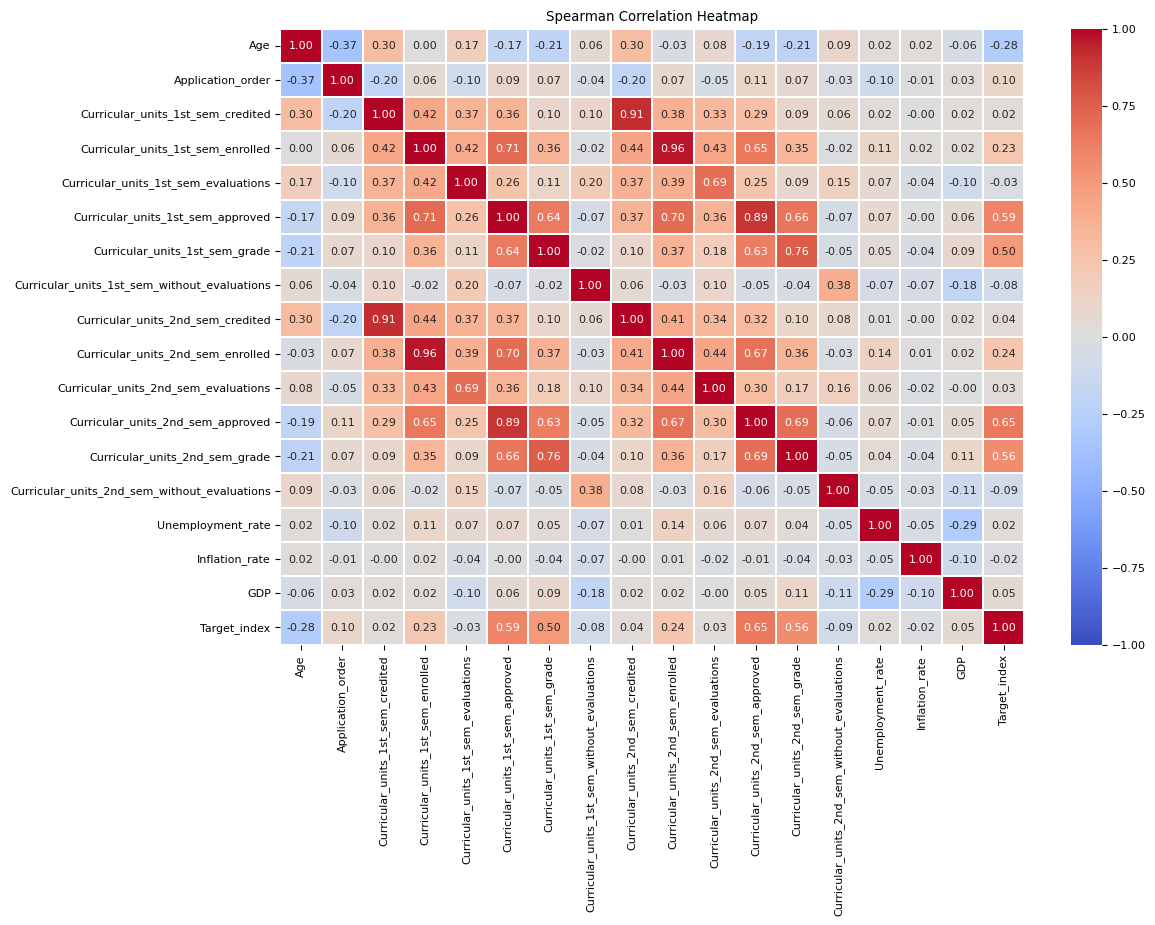

In [20]:
# Define the list of numeric features
num_features = ['Age','Application_order',
       'Curricular_units_1st_sem_credited',
       'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved', 
       'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved', 
       'Curricular_units_2nd_sem_grade',
       'Curricular_units_2nd_sem_without_evaluations', 
       'Unemployment_rate', 'Inflation_rate', 'GDP', 'Target_index']

# Assemble numeric features into a vector column
vector_assembler = VectorAssembler(inputCols=num_features, outputCol="features")
data_transformed = vector_assembler.transform(data_cleaned)

# Compute correlation matrix using Spearman's method
correlation_matrix = Correlation.corr(data_transformed, "features", method="spearman").head()[0]

# Convert correlation matrix to Pandas DataFrame for visualization
corr_array = correlation_matrix.toArray()
corr_df = pd.DataFrame(corr_array, index=num_features, columns=num_features)

# Plot heatmap using Seaborn
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 8})
hm = sns.heatmap(corr_df, cmap='coolwarm', annot=True, fmt='.2f', 
                 linewidths=.2, vmin=-1, vmax=1, center=0)
plt.title("Spearman Correlation Heatmap")
plt.show()

# Feature Engineering: Averaging Academic Data Across Semesters 🧠
### 🔹 Step 1: Created Features

In [22]:
data_with_avgs = data_cleaned.withColumn("avg_credited", 
    (col("Curricular_units_1st_sem_credited") + col("Curricular_units_2nd_sem_credited")) / 2)

data_with_avgs = data_with_avgs.withColumn("avg_enrolled", 
    (col("Curricular_units_1st_sem_enrolled") + col("Curricular_units_2nd_sem_enrolled")) / 2)

data_with_avgs = data_with_avgs.withColumn("avg_evaluations", 
    (col("Curricular_units_1st_sem_evaluations") + col("Curricular_units_2nd_sem_evaluations")) / 2)

data_with_avgs = data_with_avgs.withColumn("avg_approved", 
    (col("Curricular_units_1st_sem_approved") + col("Curricular_units_2nd_sem_approved")) / 2)

data_with_avgs = data_with_avgs.withColumn("avg_grade", 
    (col("Curricular_units_1st_sem_grade") + col("Curricular_units_2nd_sem_grade")) / 2)

data_with_avgs = data_with_avgs.withColumn("avg_without_evaluations", 
    (col("Curricular_units_1st_sem_without_evaluations") + col("Curricular_units_2nd_sem_without_evaluations")) / 2)

### 🔹 Step 2: Remove Redundant Semester Columns ✂️

In [24]:
columns_to_remove = [
    "Curricular_units_1st_sem_credited", "Curricular_units_2nd_sem_credited",
    "Curricular_units_1st_sem_enrolled", "Curricular_units_2nd_sem_enrolled",
    "Curricular_units_1st_sem_evaluations", "Curricular_units_2nd_sem_evaluations",
    "Curricular_units_1st_sem_approved", "Curricular_units_2nd_sem_approved",
    "Curricular_units_1st_sem_grade", "Curricular_units_2nd_sem_grade",
    "Curricular_units_1st_sem_without_evaluations", "Curricular_units_2nd_sem_without_evaluations"
]

data_final = data_with_avgs.drop(*columns_to_remove)
#data_final.printSchema()

## Correlation Analysis After Feature Engineering 📊


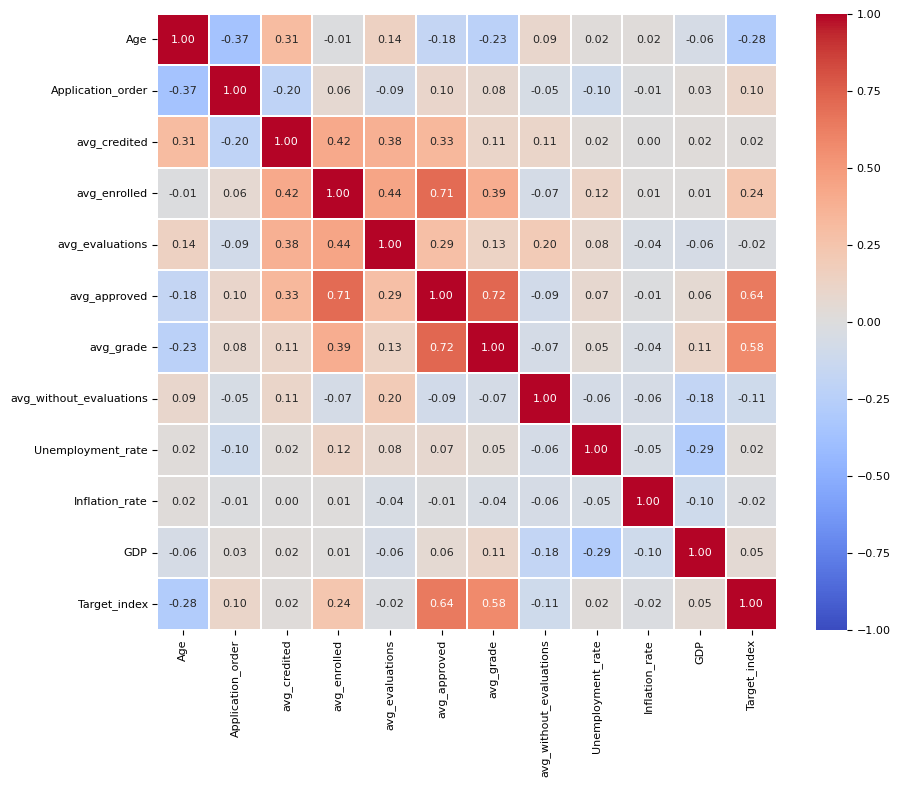

In [26]:
num_features = ['Age', 'Application_order','avg_credited', 'avg_enrolled', 
                              'avg_evaluations', 'avg_approved',
                              'avg_grade', 'avg_without_evaluations', 
                              'Unemployment_rate', 'Inflation_rate', 
                              'GDP', 'Target_index']

# Assemble numeric features into a vector column
vector_assembler = VectorAssembler(inputCols=num_features, outputCol="features")
data_transformed = vector_assembler.transform(data_final)

# Compute correlation matrix using Spearman's method
correlation_matrix = Correlation.corr(data_transformed, "features", method="spearman").head()[0]

# Convert correlation matrix to Pandas DataFrame for visualization
corr_array = correlation_matrix.toArray()
corr_df = pd.DataFrame(corr_array, index=num_features, columns=num_features)

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 8})
hm = sns.heatmap(corr_df, cmap='coolwarm', annot=True, fmt='.2f', 
                 linewidths=.2, vmin=-1, vmax=1, center=0)
plt.show()

## ✂️ Feature Removal: Unemployment_rate, Inflation_rate, GDP, avg_enrolled, avg_grade.
Based on the correlation matrix, the variables **Unemployment_rate**, **Inflation_rate**, and **GDP** show very low correlation with the target variable Target_index (all |r| < 0.05). They also have minimal correlation with other features.

In addition, both **avg_enrolled** and **avg_grade** had high correlation with avg_approved (r > 0.7), which can lead to multicollinearity — a condition that may negatively affect the model’s stability and interpretability.

🧹 Therefore, these variables were removed to:
- Simplify the model
- Reduce noise
- Avoid unnecessary multicollinearity
- Prevent redundancy and multicollinearity between features

In [28]:
columns_to_drop = ['Unemployment_rate', 'Inflation_rate', 'GDP','avg_enrolled','avg_grade']
data_final = data_final.drop(*columns_to_drop)

data_final.printSchema()

root
 |-- Marital_status: integer (nullable = true)
 |-- Application_mode: integer (nullable = true)
 |-- Application_order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime/evening_attendance: integer (nullable = true)
 |-- Previous_qualification: integer (nullable = true)
 |-- Mother_qualification: integer (nullable = true)
 |-- Father_qualification: integer (nullable = true)
 |-- Mother_occupation: integer (nullable = true)
 |-- Father_occupation: integer (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition_fees_up_to_date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship_holder: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Target_index: double (nullable = false)
 |-- avg_credited: double (nullable = true)
 |-- avg_evaluations: double (nullable = true)
 |-- avg_approved: double (nullable = true)
 |-- avg_without_evaluations: double (nullable 

## Data Consistency Check: Unexpected Graduation Cases 🔍
There are 75 records where all academic-related features (such as credited, enrolled, approved, and grade) are equal to zero, 
yet the students are labeled as 'Graduate' (Target_index = 2).

- This contradicts logical academic progression and may indicate inconsistencies or data entry errors.
- Therefore, we will consider these records as outliers and remove them from the dataset to improve data quality and model accuracy.


In [31]:
# Check for inconsistent rows: graduates with zero approved courses
data_final.filter(
    (col("avg_approved") == 0) & (col("Target_index") == 2.0)
).toPandas()

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age,Target_index,avg_credited,avg_evaluations,avg_approved,avg_without_evaluations
0,1,1,3,2,1,1,1,1,10,9,...,0,1,0,1,21,2.0,0.0,0.0,0.0,0.0
1,1,1,3,2,1,1,13,14,6,4,...,0,1,1,1,19,2.0,0.0,0.0,0.0,0.0
2,1,1,4,2,1,1,1,1,10,11,...,0,1,0,0,20,2.0,0.0,0.0,0.0,0.0
3,1,1,1,2,1,1,1,14,4,10,...,0,1,0,0,18,2.0,0.0,0.0,0.0,0.0
4,1,12,1,2,1,1,3,1,3,11,...,0,1,1,0,24,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,8,2,2,1,1,3,1,3,7,...,0,1,0,1,18,2.0,0.0,0.0,0.0,0.0
71,1,1,1,2,1,1,1,28,5,6,...,0,1,1,0,19,2.0,0.0,0.0,0.0,0.0
72,1,1,1,2,1,1,3,1,5,5,...,0,1,0,0,18,2.0,0.0,0.0,0.0,0.0
73,1,1,2,2,1,1,23,28,5,10,...,0,1,1,0,19,2.0,0.0,0.0,0.0,0.0


In [32]:
# Remove outliers: students labeled as Graduate (2.0) with no approved courses
data_final = data_final.filter(~((col("avg_approved") == 0) & (col("Target_index") == 2.0)))

In [35]:
# Check the rows with zero average grade and students being graduade
data_final.filter(
    (col("avg_approved") == 0) & (col("Target_index") == 2.0)
).toPandas()

,Marital_status,Application_mode,Application_order,Course,Daytime/evening_attendance,Previous_qualification,Mother_qualification,Father_qualification,Mother_occupation,Father_occupation,...,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age,Target_index,avg_credited,avg_evaluations,avg_approved,avg_without_evaluations


### Removing 'Enrolled' from Target_index
Since our goal is to predict student dropouts and identify those needing support,
we converted the problem into a binary classification by removing the intermediate 'Enrolled'. 

In [38]:
print("Class distribution before removing 'Enrolled' (Target_index = 1.0):")
data_final.groupby("Target_index").count().show()

data_final = data_final.filter(col("Target_index") != 1.0)

data_final = data_final.withColumn(
    "Target_index", 
    when(data_final["Target_index"] == 2.0, 1.0).otherwise(0.0)
)
print("Class distribution after removing 'Enrolled': 'Graduate' (2.0) converted to 1.0, 'Dropout' (0.0) remained unchanged.")
data_final.groupby("Target_index").count().show()

Class distribution before removing 'Enrolled' (Target_index = 1.0):
+------------+-----+
|Target_index|count|
+------------+-----+
|         0.0| 1421|
|         1.0|  794|
|         2.0| 2134|
+------------+-----+

Class distribution after removing 'Enrolled': 'Graduate' (2.0) converted to 1.0, 'Dropout' (0.0) remained unchanged.
+------------+-----+
|Target_index|count|
+------------+-----+
|         0.0| 1421|
|         1.0| 2134|
+------------+-----+



In [39]:
data_final.printSchema()

root
 |-- Marital_status: integer (nullable = true)
 |-- Application_mode: integer (nullable = true)
 |-- Application_order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime/evening_attendance: integer (nullable = true)
 |-- Previous_qualification: integer (nullable = true)
 |-- Mother_qualification: integer (nullable = true)
 |-- Father_qualification: integer (nullable = true)
 |-- Mother_occupation: integer (nullable = true)
 |-- Father_occupation: integer (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition_fees_up_to_date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship_holder: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Target_index: double (nullable = false)
 |-- avg_credited: double (nullable = true)
 |-- avg_evaluations: double (nullable = true)
 |-- avg_approved: double (nullable = true)
 |-- avg_without_evaluations: double (nullable 

# 📈 Model Building – Logistic Regression 

At this stage, we trained a logistic regression model to predict the likelihood that a student will successfully graduate, using the Target_index column, where:

0.0 = Dropout
1.0 = Graduate

#### 🧠 Why Logistic Regression? 
Logistic Regression is a simple yet powerful algorithm for binary classification problems. It:

- Outputs probabilities indicating how likely a sample belongs to each class.
- Is interpretable, fast to train, and suitable for high-dimensional data.
- Performs well when features are properly encoded and scaled.

#### 🔹 Steps:
1. **Preprocessed categorical features** using One-Hot Encoding.
2. **Assembled** all features (categorical and numeric) into a single features vector.
3. **Scaled the features** using StandardScaler to improve model performance.
4. **Trained** a logistic regression model on the training set.
5. **Generated predictions** on the test set, including class probabilities and final predictions.
6. **Evaluated** the model using AUC (Area Under ROC Curve), as well as Accuracy, Precision, Recall, and F1-score.

In [41]:
categorical_cols = ['Marital_status', 'Application_mode', 'Course','Daytime/evening_attendance', 'Previous_qualification',
                    'Mother_qualification', 'Father_qualification', 'Mother_occupation',
                    'Father_occupation', 'Displaced','Debtor',
                    'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder']

numeric_cols = ['Age','Application_order', 'avg_credited', 
                    'avg_evaluations', 'avg_approved', 'avg_without_evaluations']

for col in categorical_cols:
    encoder = OneHotEncoder(inputCol=col, outputCol=col + "_vec", handleInvalid="keep")
    data_final = encoder.fit(data_final).transform(data_final)

feature_cols = [col + "_vec" for col in categorical_cols] + numeric_cols
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_final = assembler.transform(data_final)

scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures", withStd = True, withMean = True)
scaler_model = scaler.fit(data_final)
data_final = scaler_model.transform(data_final)
train_data, test_data = data_final.randomSplit([0.8, 0.2], seed=1234)

Columns in feature vector:
['Marital_status_vec', 'Application_mode_vec', 'Course_vec', 'Daytime/evening_attendance_vec', 'Previous_qualification_vec', 'Mother_qualification_vec', 'Father_qualification_vec', 'Mother_occupation_vec', 'Father_occupation_vec', 'Displaced_vec', 'Debtor_vec', 'Tuition_fees_up_to_date_vec', 'Gender_vec', 'Scholarship_holder_vec', 'Age', 'Application_order', 'avg_credited', 'avg_evaluations', 'avg_approved', 'avg_without_evaluations']


In [50]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

logreg = LogisticRegression(
    featuresCol="scaledFeatures",
    labelCol="Target_index",
    maxIter=100
)
logreg_model = logreg.fit(train_data)
logreg_predictions = logreg_model.transform(test_data)

evaluator_auc = BinaryClassificationEvaluator(
    labelCol="Target_index",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = evaluator_auc.evaluate(logreg_predictions)
print(f"🔵 Logistic Regression AUC: {auc:.4f}")

logreg_predictions.select("Target_index", "probability", "prediction").show(10, truncate=False)

🔵 Logistic Regression AUC: 0.9307
+------------+------------------------------------------+----------+
|Target_index|probability                               |prediction|
+------------+------------------------------------------+----------+
|0.0         |[0.9989065867581955,0.0010934132418044529]|0.0       |
|1.0         |[0.10914441038086664,0.8908555896191334]  |1.0       |
|0.0         |[0.9999995170178436,4.829821563800962E-7] |0.0       |
|1.0         |[0.008672725635204737,0.9913272743647953] |1.0       |
|0.0         |[0.9982044539226474,0.00179554607735255]  |0.0       |
|0.0         |[0.999346118033346,6.538819666539464E-4]  |0.0       |
|0.0         |[0.9987886760074399,0.001211323992560076] |0.0       |
|0.0         |[0.9999619382202711,3.8061779728870704E-5]|0.0       |
|1.0         |[0.021261860226898105,0.9787381397731019] |1.0       |
|0.0         |[0.9830183787436982,0.01698162125630176]  |0.0       |
+------------+------------------------------------------+----------+


In [45]:
y_true = logreg_predictions.select("Target_index").toPandas()
y_pred = logreg_predictions.select("prediction").toPandas()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"✅ Accuracy:  {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall:    {rec:.4f}")
print(f"✅ F1-Score:  {f1:.4f}")

✅ Accuracy:  0.9027
✅ Precision: 0.8982
✅ Recall:    0.9520
✅ F1-Score:  0.9243


## 🔍 Conclusions
The model demonstrates a high ability to detect true dropouts (high recall) without generating excessive false positives (high precision).
The AUC score reflects excellent class separation between students likely to succeed and those at risk of dropping out.
This makes the model a practical and effective early-warning tool for identifying at-risk students — supporting academic institutions in monitoring and early intervention strategies.